In [1]:
import networkx
print(networkx.__version__)

2.6.3


In [2]:
from ssh2.session import Session
import socket

class SSHCommand:
    address = ""
    username = ""
    password = ""
    
    def __init__(self, address="127.0.0.1", username="none", password="none"):
        self.address = address
        self.username = username
        self.password = password
    
    def execute(self, command = ""):
        sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        sock.connect((self.address, 22))
        session = Session()
        session.handshake(sock)
        session.userauth_password(self.username, self.password)
        channel = session.open_session()
        channel.execute(command)
        result = ""
        size, result = channel.read()
        while size > 0:
            size, data = channel.read()
            result = result + data
        channel.close()
        session.disconnect()
        return result.decode('ascii')


In [3]:
ssh = SSHCommand(address='172.16.1.17', username='venator', password='cpt701cpt701')
result = ssh.execute('echo -e \"timestamp,duration,id.orig_h,id.resp_h,orig_bytes,resp_bytes,orig_pkts,resp_pkts\" && zcat /nsm/zeek/logs/2021-09-14//conn.* | jq -j \'select(.conn_state == \"SF\") | .[\"ts\"], \",\", .[\"duration\"], \",\", .[\"id.orig_h\"], \",\", .[\"id.resp_h\"], \",\", .[\"orig_bytes\"], \",\", .[\"resp_bytes\"], \",\", .[\"orig_pkts\"], \",\", .[\"resp_pkts\"], \"\n\"\'')

In [4]:
from io import StringIO
import pandas as pd

def string_to_df(data):
    return pd.read_csv(StringIO(data), sep=",")

df = string_to_df(result)
df

,timestamp,duration,id.orig_h,id.resp_h,orig_bytes,resp_bytes,orig_pkts,resp_pkts
0,1.631578e+09,0.046178,172.16.1.17,172.16.1.15,121174.0,178.0,12,16
1,1.631578e+09,0.043457,172.16.1.17,172.16.1.15,112294.0,178.0,10,18
2,1.631578e+09,0.000266,172.16.1.10,172.16.1.14,35.0,51.0,1,1
3,1.631578e+09,0.030693,172.16.1.17,172.16.1.15,120278.0,178.0,13,16
4,1.631578e+09,0.000805,172.16.1.10,172.16.1.14,35.0,51.0,1,1
...,...,...,...,...,...,...,...,...
123929,1.631664e+09,0.000625,172.16.1.10,172.16.1.14,35.0,51.0,1,1
123930,1.631664e+09,0.000616,172.16.1.10,172.16.1.14,35.0,35.0,1,1
123931,1.631664e+09,0.000729,172.16.1.10,172.16.1.14,35.0,51.0,1,1
123932,1.631664e+09,0.025303,172.16.1.17,172.16.1.15,112294.0,178.0,13,20


In [5]:
from io import StringIO
import pandas as pd
import datetime

def string_to_df(data):
    return pd.read_csv(StringIO(data), sep=",")

#print(result)
df = string_to_df(result)

ts2 = df['timestamp'].iloc[0]
orig_ip = df['id.orig_h'].iloc[0]

test = "ts,all_pkts\n"
ts_index = 0
pkts_index = 0
all_pkts = 0
origPkts = 0
respPkts = 0
df_pkts = pd.DataFrame(columns=["ts","all_pkts"])
for index,value in df['timestamp'].sort_values().items():
    ts1 = value
    ts_count = value
    if ts_count >= ts2 + 10:
        origPkts = origPkts + df['orig_pkts'].iloc[index]
        respPkts = respPkts + df['resp_pkts'].iloc[index]
        all_pkts = all_pkts + respPkts + origPkts
#        print(all_pkts)
        epoch_time = ts1
        datetime_time = datetime.datetime.fromtimestamp(epoch_time)
        test += str(datetime_time) + ',' + str(all_pkts) +'\n'
        origPkts = 0
        respPkts = 0
        all_pkts = 0
        ts2 = value
    else:
        origPkts = origPkts + df['orig_pkts'].iloc[index]
        respPkts = respPkts + df['resp_pkts'].iloc[index]
        all_pkts = all_pkts + respPkts + origPkts
#        print(all_pkts)
        origPkts = 0
        respPkts = 0

df_pkts = pd.read_csv(StringIO(str(test)), sep=",")
#print(test)
#print(df_pkts)

In [6]:
print(df['id.orig_h'],df['id.resp_h'])

0         172.16.1.17
1         172.16.1.17
2         172.16.1.10
3         172.16.1.17
4         172.16.1.10
             ...     
123929    172.16.1.10
123930    172.16.1.10
123931    172.16.1.10
123932    172.16.1.17
123933    172.16.1.17
Name: id.orig_h, Length: 123934, dtype: object 0         172.16.1.15
1         172.16.1.15
2         172.16.1.14
3         172.16.1.15
4         172.16.1.14
             ...     
123929    172.16.1.14
123930    172.16.1.14
123931    172.16.1.14
123932    172.16.1.15
123933    172.16.1.15
Name: id.resp_h, Length: 123934, dtype: object


In [7]:
print(df['orig_bytes'])

0         121174.0
1         112294.0
2             35.0
3         120278.0
4             35.0
            ...   
123929        35.0
123930        35.0
123931        35.0
123932    112294.0
123933    121190.0
Name: orig_bytes, Length: 123934, dtype: float64


In [8]:
conn_count = 0
#if df_hosts :
#    del df_hosts
df_hosts = pd.DataFrame()
#df_hosts.iloc[0] = pd.DataFrame(columns=["id.orig_h","id.resp_h", "duration_avg", "packets_avg"])
dict = {'id.orig_h': '0.0.0.0', 'id.resp_h': '0.0.0.0', 'duration_avg': 0.0, 'packets_avg': 0.0, 'conn_count': 0}
df_hosts = df_hosts.append(dict, ignore_index = True)
df_hosts
df = df.sort_values(['id.orig_h','id.resp_h'])
df
orig_ip = df['id.orig_h'].iloc[0]
resp_ip = df['id.resp_h'].iloc[0]
#print(orig_ip)
#print(resp_ip)
duration = 0.0
pktCount = 0
index_count = 0

for index,origIP in df['id.orig_h'].sort_values().items():
    origIPtmp = origIP
    respIPtmp = df['id.resp_h'].iloc[index]
    durationtmp = df['duration'].iloc[index]
    pktOrigtmp = df['orig_pkts'].iloc[index]
    pktResptmp = df['resp_pkts'].iloc[index]

    alreadyHere = ((df_hosts['id.orig_h'] == origIPtmp) & (df_hosts['id.resp_h'] == respIPtmp)).any().any()
    if alreadyHere == True:
      # print(f'source and destination IP found. Updating dataframe row for.\t',origIPtmp,'\t',respIPtmp)
       pktCount = pktOrigtmp + pktResptmp
       indexTmp = df_hosts.index[(df_hosts['id.orig_h']==origIPtmp) & (df_hosts['id.resp_h']==respIPtmp)].tolist()
       indexNumber = indexTmp[0]
    #fix get packet_avg and duration_avg from current df_hosts dataframe index
       conn_count = df_hosts['conn_count'].iloc[indexNumber]
       packet_count = df_hosts['packets_avg'].iloc[indexNumber]
       duration = df_hosts['duration_avg'].iloc[indexNumber]
       packet_count = packet_count + pktCount
       duration = duration + durationtmp
 #      print(df_hosts['conn_count'].iloc[indexNumber], '\t', indexNumber)
       conn_count = conn_count + 1
       packet_count = packet_count / conn_count
       duration = duration / conn_count
       df_hosts.at[indexNumber,'duration_avg']= duration
       df_hosts.at[indexNumber,'packets_avg'] = packet_count
       df_hosts.at[indexNumber,'conn_count'] = conn_count

    else:
      # print(f'source and destination IP not found. Adding to dataframe.\t',origIPtmp,'\t',respIPtmp)
       conn_count = 1
#       print(conn_count)
       pktCount = pktOrigtmp + pktResptmp
       duration = durationtmp
       dict = {'id.orig_h': origIPtmp, 'id.resp_h': respIPtmp, 'duration_avg': duration, 'packets_avg': pktCount, 'conn_count': conn_count}
       df_hosts = df_hosts.append(dict, ignore_index = True)

#df_hosts.dropna(subset = ["duration_avg"], inplace=True)



In [10]:
index_names = df_hosts[ df_hosts['id.orig_h'] == "0.0.0.0" ].index
df_hosts.drop(index_names, inplace = True)
df_hosts = df_hosts.reset_index(drop=True)
pd.set_option("display.max_rows", None, "display.max_columns", None)


In [11]:
df_hosts = df_hosts.fillna(0)
df_hosts

,conn_count,duration_avg,id.orig_h,id.resp_h,packets_avg
0,10.0,0.005331,172.16.1.1,172.16.1.15,1.889493
1,239.0,0.000001,172.16.1.1,172.16.1.14,0.008404
2,1.0,0.609876,172.16.1.1,208.91.0.89,27.000000
3,100240.0,0.000000,172.16.1.10,172.16.1.14,0.000020
4,10319.0,0.016594,172.16.1.10,172.16.1.15,0.002908
5,666.0,0.000046,172.16.1.10,172.16.1.2,0.003008
6,1.0,0.113746,172.16.1.10,23.37.116.27,8.000000
7,22.0,0.004827,172.16.1.10,23.206.124.25,0.381866
8,56.0,2.123946,172.16.1.10,172.16.1.5,0.949344
9,95.0,0.007535,172.16.1.10,208.91.0.89,0.256919


In [12]:
import networkx
import matplotlib.pyplot as plt
import pygraphviz
from networkx.drawing.nx_agraph import write_dot
network=networkx.Graph()
#plt.figure(figsize=(10000, 10000))
#plt.rcParams['figure.figsize'] = [60, 60]

## Drawing the graph
In this section, we draw the actual graph.
All responding node colors and sizes are based on the connection count, average number of packets between the originating and responding nodes, and the average duration between the originating and responding nodes. For example:
A blue responding node would mean a duration average below 1 second.
A circle shaped node would mean a low number of connections (below 24 connections).
A small node size would mean a low number of average packets.

A beacon could be represented by a high connection count ( a triangle shaped node ) that is low in packet size ( small node) and low in duration average ( blue node )

![Node Legend](NetworkBeaconLegend.png)

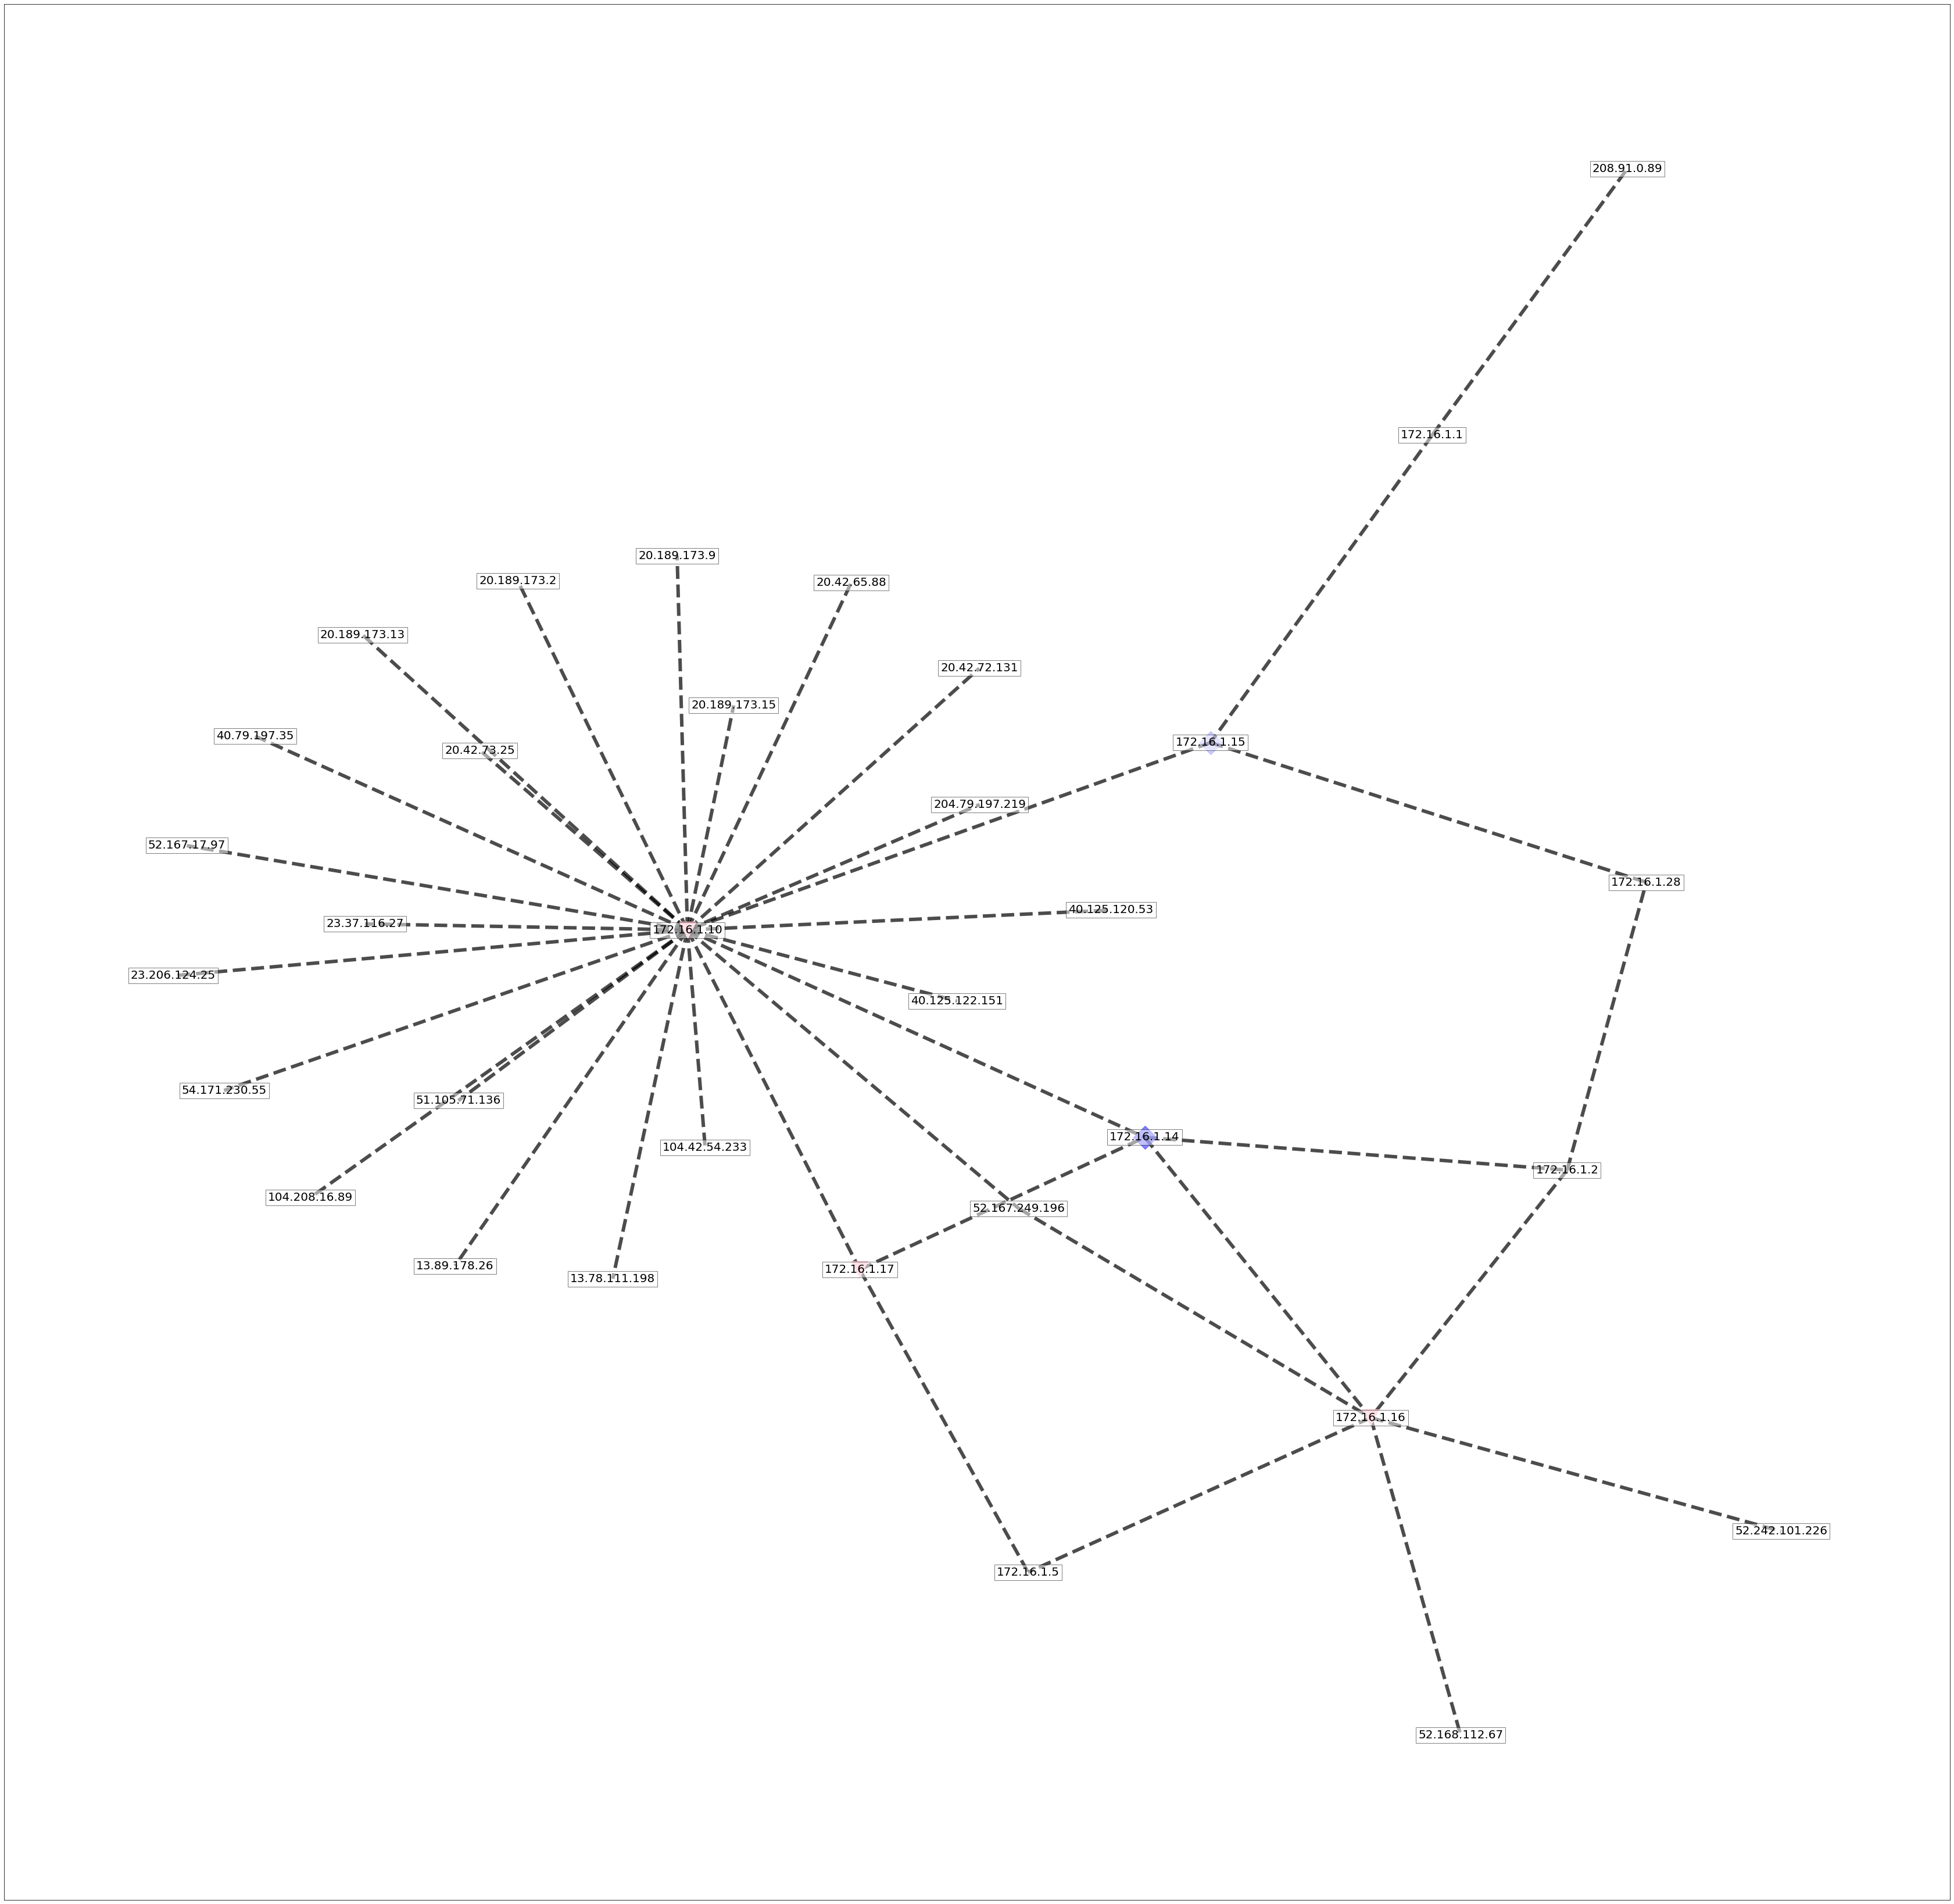

<Figure size 720000x720000 with 0 Axes>

In [17]:
for index,origIP in df_hosts['id.orig_h'].sort_values().items():
    orig_h = origIP
    resp_h = df_hosts['id.resp_h'].iloc[index]
    duration_avg = df_hosts['duration_avg'].iloc[index]
    packets_avg = df_hosts['packets_avg'].iloc[index]
    conn_count = df_hosts['conn_count'].iloc[index]
    if conn_count > 1000:
        node_shape = "v"
    elif conn_count >= 100 and conn_count < 1000:
        node_shape = "<"
    elif conn_count >= 50 and conn_count < 100:
        node_shape = ">"
    elif conn_count >= 25 and conn_count < 50:
        node_shape = "^"
    elif conn_count <= 24:
        node_shape = "o"
    if duration_avg > 1000:
        node_color = 'red'
    elif duration_avg > 100 and duration_avg < 1000:
        node_color = 'yellow'
    elif duration_avg > 10 and duration_avg < 100:
        node_color = 'green'
    elif duration_avg < 10:
        node_color = 'blue'
    if packets_avg > 1000:
        node_size = 8000
    elif packets_avg >= 100 and packets_avg < 1000:
        node_size = 4000
    elif packets_avg >= 10 and packets_avg < 100:
        node_size = 2000
    elif packets_avg < 10:
        node_size = 800
   
    if (node_color == "blue" and node_shape == "v") and (node_size == 800 or node_size == 2000):
       network.add_node(orig_h,label=orig_h)
       network.add_node(resp_h,label=resp_h)
       network.add_edge(orig_h,resp_h, width=6)
       pos = networkx.kamada_kawai_layout(network)
       networkx.draw_networkx_nodes(network, pos, node_size=node_size, nodelist=[orig_h], node_shape=node_shape, node_color="pink", alpha=1.0)
       networkx.draw_networkx_nodes(network, pos, node_size=node_size, nodelist=[resp_h], node_shape="D", node_color=node_color, alpha=0.2)
pos = networkx.kamada_kawai_layout(network)
networkx.draw_networkx_edges(network, pos, width=6, alpha=0.7, edge_color='black', style='dashed')

import matplotlib.patches as mpatches
label_options = {"ec": "k", "fc": "white", "alpha": 0.5}
networkx.draw_networkx_labels(network, pos, font_size=20, bbox=label_options)
#fig, ax = plt.subplots()
#red_patch = mpatches.Patch(color='red', label='The red data')
#ax.legend(handles=[red_patch])
plt.figure(figsize=(10000, 10000))
plt.rcParams['figure.figsize'] = [60, 60]
plt.show()


### Node Legend
![Node Legend](NetworkBeaconLegend.png)

In [ ]:
write_dot(network,'network.dot')